(26607817.21219806, 705186.40639658179, 5.0, 5.0, 2382833.843385078, 63152.194020881361)


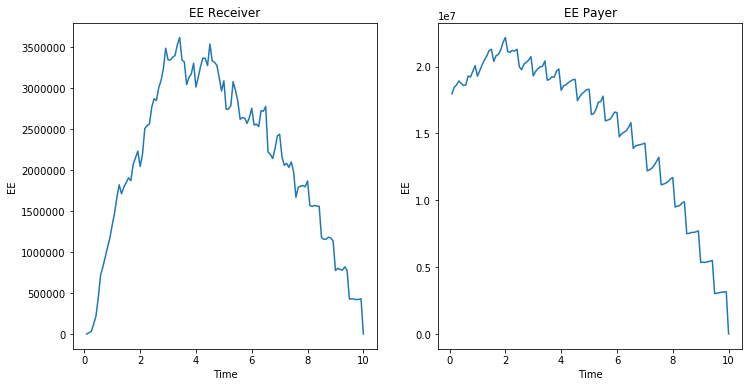

done


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec 02 21:54:28 2017

@author: Lejing
"""
import numpy as np
import matplotlib.pyplot as plt
import fmt
import pandas as pd

from swap import Swap,priceSwap
from marketSetup import simulateOIS,simulateSurvivalProb,simulateOIS_IMM
from valuationAdjustment import calculatePVEE,calculateUniCVA,calculateUniDVA,\
                        calculateNetUniCVA,calculateBiCVA,calculateBiDVA,\
                        calculateNetBiCVA
from IMM_fun import CalcEAD,RegulatoryCapital,EffectiveMaturity

num_simulation = 50000
sim_freq = 12

### Interest rate parameters
spread = 0.005 # spread i.e. f_LIBOR=f_OIS+spread
f0_OIS = 0.02
f0_LIBOR = f0_OIS+spread

### swap parameters
freq = 2
maturity = 10
coupon = 0.0265
notional = 150000000.

### Interest rate model parameters
sigma_r = 0.02
c = 0.35
kappa1,kappa2 = 0.02,0.1
rho_inf = 0.4
nu = np.sqrt(1./c/c - 1. - 2.*(rho_inf/c - 1.))
rho_x = (rho_inf/c - 1.)/nu
sigma_l = c * sigma_r
sigma1 = sigma_l
sigma2 = nu*sigma1

### Credit curve parameters
lbda0_B, lbda0_C = 0.01,0.03
sigmaB, sigmaC = 0.005,0.01
kappaB, kappaC = 0.1,0.1

rho_Bf, rho_Cf = 0.1,0.1
rho_BC = 0.75
rho_Br, rho_Cr = 0.25,0.25
rho_B1 = rho_Bf   # corr b/w lbdaB and x1
rho_C1 = rho_Cf   # corr b/w lbdaC and x1
rho_B2 = rho_Br*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_B1   # corr b/w lbdaB and x2
rho_C2 = rho_Cr*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_C1   # corr b/w lbdaC and x2

### correlation matrix among lbdaB,lbdaC,x1,x2 for simulation
corr = np.array([[1., rho_BC, rho_B1, rho_B2],\
                 [rho_BC, 1., rho_C1, rho_C2],\
                 [rho_B1, rho_C1, 1., rho_x],\
                 [rho_B2, rho_C2, rho_x, 1.]])
chol = np.linalg.cholesky(corr)

### Credit Mitigation
D = 0.0375   # intensity threshold for downgrade provision
collateral = 5000000.
rr = 0.4    # recovery rate


swap = Swap(maturity, coupon, freq, notional)
swap.__str__()

Tis = np.arange(1./freq,maturity+1e-6,1./freq)
ts = np.arange(1./sim_freq,maturity+1e-6,1./sim_freq)

num_simulation = 500

prices_payer=[]
prices_receiver = []
P_OISs = []
P_LIBORs = []
X_Bs = []
X_Cs = []
lbdaBs = []
lbdaCs = []
wts = []

P_OIS = []

for num in range(num_simulation):
    # simulate correlated 4-D brownian motion
    wt = chol.dot(np.random.normal(0,1./np.sqrt(sim_freq),(4,sim_freq*maturity)))
    wts.append(wt)
    P_OIS, P_LIBOR = simulateOIS_IMM(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity, f0_OIS, spread,ts,Tis,wt)
    X_B,X_C,lbdaB,lbdaC = simulateSurvivalProb(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt)
    price_one_path=[]
    price_one_path_payer = []
    for i in range(maturity*sim_freq):
        p =priceSwap(swap, 'payer', P_OIS, P_LIBOR, i, ts, Tis,sim_freq)
        price_one_path_payer.append(p)
        price_one_path.append(-p)
        
    prices_payer.append(price_one_path_payer)
    prices_receiver.append(price_one_path)
    P_OISs.append(P_OIS)
    P_LIBORs.append(P_LIBOR)
    X_Bs.append(X_B)
    X_Cs.append(X_C)
    lbdaBs.append(lbdaB)
    lbdaCs.append(lbdaC)
    
#print "payer",np.average(prices_payer,axis=0)
#print prices_payer


##### 1 Plot $PVEE(T)$ as seen from B as payer and receiver respectively
switch_collateral = False
switch_downProv = False
collateral = 0
D = 0
PVEE_payer,EE_payer = calculatePVEE(lbdaCs,P_OISs,X_Cs,prices_payer,switch_collateral,switch_downProv,collateral,D)
PVEE_receiver,EE_receiver = calculatePVEE(lbdaCs,P_OISs,X_Cs,prices_receiver,switch_collateral,switch_downProv,collateral,D)
#print "Payer",PVEE_payer
#print "Receiver",PVEE_receiver



alpha = 1.4
LGD = 0.4
PD = 0.01
EAD_payer = CalcEAD('2',EE_payer,0,alpha,sim_freq)
EAD_receiver = CalcEAD('2',EE_receiver,0,alpha,sim_freq)
M_payer = EffectiveMaturity(EE_payer,sim_freq)
M_receiver = EffectiveMaturity(EE_receiver,sim_freq)
RC_payer = RegulatoryCapital(EAD_payer,M_payer,LGD,PD)
RC_receiver = RegulatoryCapital(EAD_receiver,M_receiver,LGD,PD)



('EAD payer', 26607817.21219806, 'EAD receiver', 705186.40639658179, 'M payer', 5.0, 'M receiver', 5.0, 'RC payer', 2382833.843385078, 'RC receiver', 63152.194020881361)


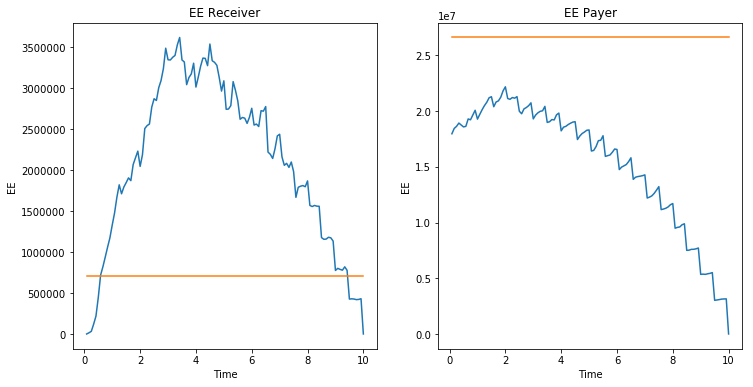

done


In [14]:
print('EAD payer',EAD_payer,'EAD receiver',EAD_receiver,'M payer',M_payer,'M receiver',M_receiver,'RC payer',RC_payer,'RC receiver', RC_receiver)

plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(ts,EE_receiver)
plt.plot(ts,EAD_receiver*np.ones(len(EE_receiver)))
plt.xlabel('Time')
plt.ylabel('EE')
plt.title('EE Receiver')


plt.subplot(1,2,2)
plt.plot(ts,EE_payer)
plt.plot(ts,EAD_payer*np.ones(len(EE_payer)))
plt.xlabel('Time')
plt.ylabel('EE')
plt.title('EE Payer')

plt.show()
print "done"

In [12]:
sum(EE_payer)/sum(EE_payer[:11])



8.8613637663141596